## import

In [4]:

from IPython.display import Image,Video
from matplotlib import pyplot as plt

import cv2
import argparse
import sys
import numpy as np
import pandas as pd
import os.path
import os

from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from paddleocr import PaddleOCR

C:\Users\jpedr\AppData\Roaming\Python\Python39\site-packages\paddle\vision\transforms\functional_pil.py:36: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': Image.NEAREST,
C:\Users\jpedr\AppData\Roaming\Python\Python39\site-packages\paddle\vision\transforms\functional_pil.py:37: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': Image.BILINEAR,
C:\Users\jpedr\AppData\Roaming\Python\Python39\site-packages\paddle\vision\transforms\functional_pil.py:38: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  'bicubic': Image.BICUBIC,
C:\Users\jpedr\AppData\Roaming\Python\Python39\site-packages\paddle\vision\transforms\functional_pil.py:39: DeprecationWarning: BOX is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BO

In [5]:
input_path = r'../renata.jpeg'

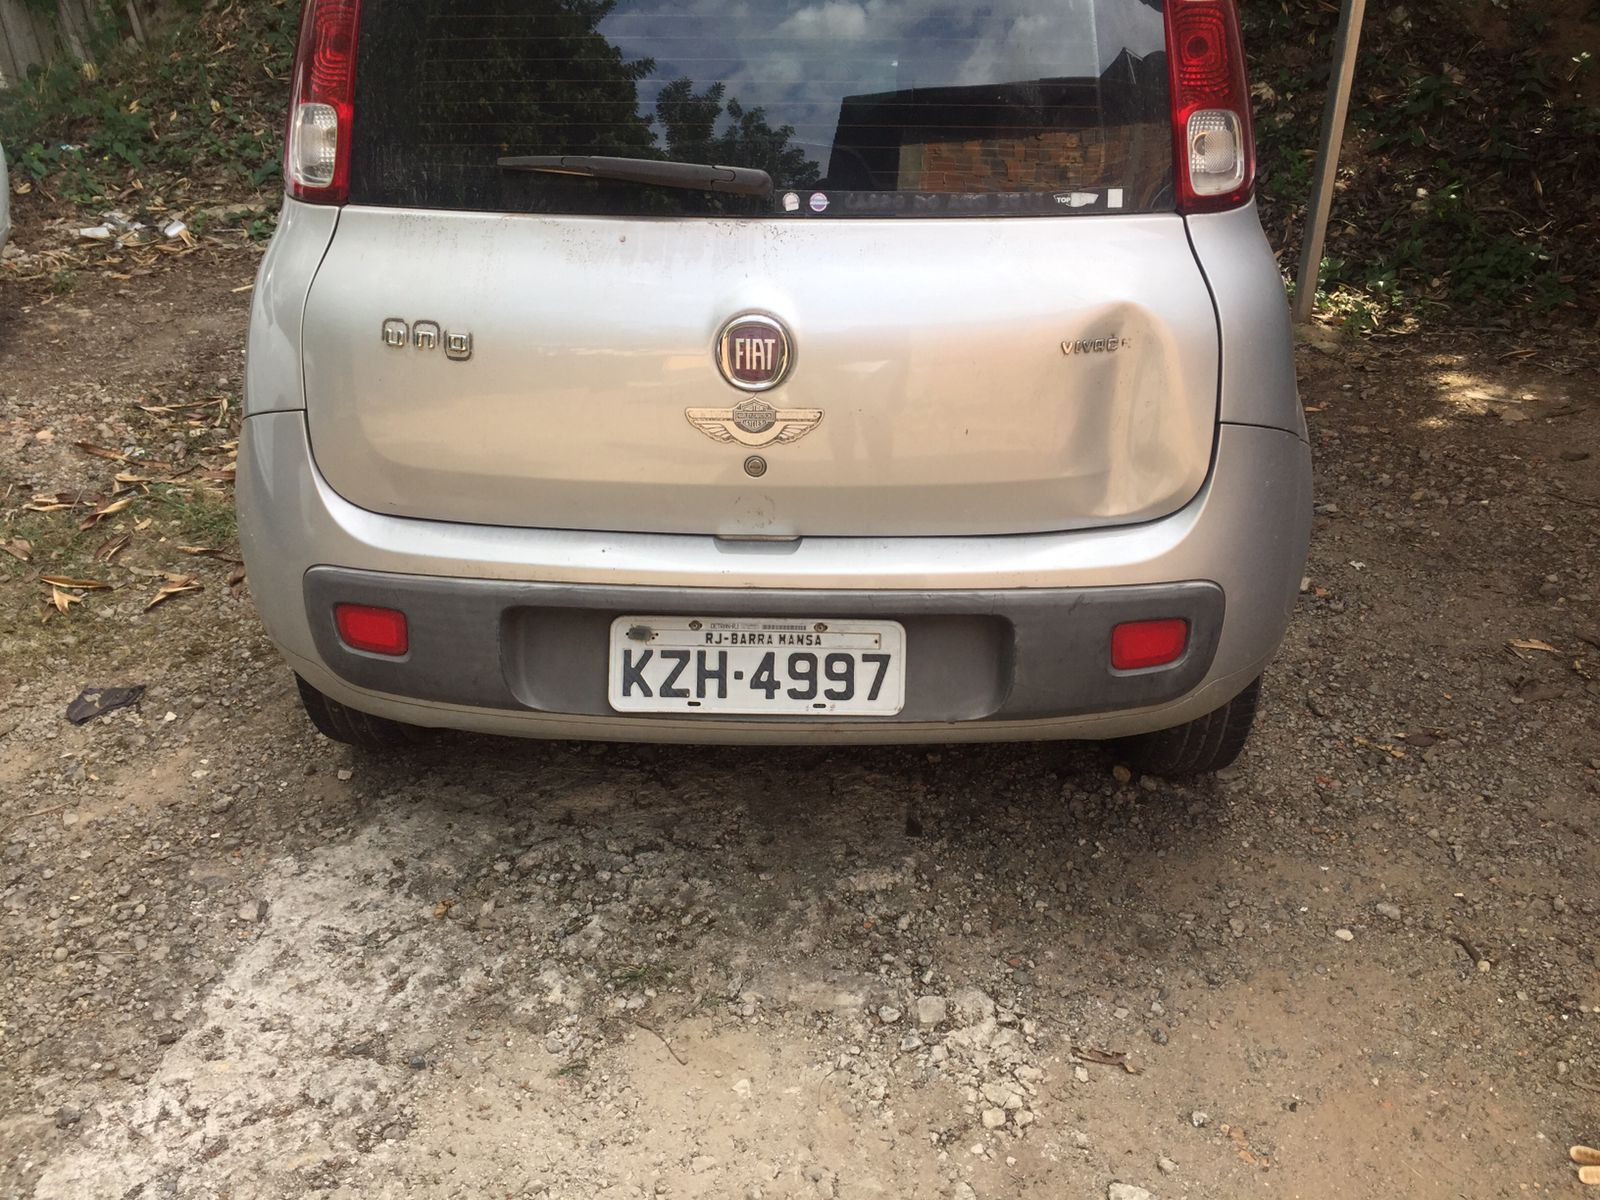

In [6]:
Image(input_path)
#Video(input_path)

## imputando

In [7]:
cap = cv2.VideoCapture(input_path)

## YOLO Plate Detection
### parametros

In [8]:


confThreshold = 0.5  
nmsThreshold = 0.4 

inpWidth = 416    
inpHeight = 416    


In [9]:

classesFile = "yolo_utils/classes.names";

In [10]:

classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

In [11]:

modelConfiguration = r"yolo_utils/darknet-yolov3.cfg";
modelWeights = r"yolo_utils/lapi.weights";

In [12]:
net = cv2.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

In [13]:

def getOutputsNames(net):

    layersNames = net.getLayerNames()

    return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]

In [33]:
def drawPred(classId, conf, left, top, right, bottom, frame):
    
    cv2.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 3)

    label = '%.2f' % conf


    if classes:
        assert(classId < len(classes))
        label = '%s:%s' % (classes[classId], label)


    labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv2.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine), (0, 0, 255), cv2.FILLED)
    #cv.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine),    (255, 255, 255), cv.FILLED)
    cv2.putText(frame, label, (left, top), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 2)

In [15]:

def postprocess(frame, outs):
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]
    

    classIds = []
    confidences = []
    boxes = []
    for out in outs:
       
        for detection in out:

            scores = detection[5:]
            classId = np.argmax(scores)
          
            confidence = scores[classId]
            '''if detection[4]>confThreshold:
                print(detection[4], " - ", scores[classId], " - th : ", confThreshold)
                print(detection)'''
            if confidence > confThreshold:
                center_x = int(detection[0] * frameWidth)
                center_y = int(detection[1] * frameHeight)
                width = int(detection[2] * frameWidth)
                height = int(detection[3] * frameHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])

    
    cropped=None
    indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    for i in indices:
        i = i[0]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        

        bottom = top+10 + height+10
        right = left+10 + width+10
        top = top+10
        bottom = bottom+10
        left = left+10
        right = right+10
        print(bottom,top,left,right)
        cropped = frame[top:bottom, left:right].copy()

        drawPred(classIds[i], confidences[i], left, top, right, bottom, frame)
    if cropped is not None:
        return cropped

### Reconhecimento


733 627 637 915


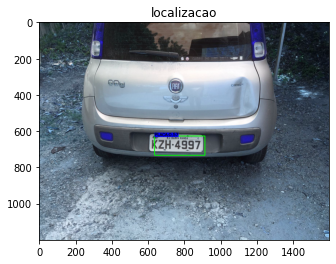

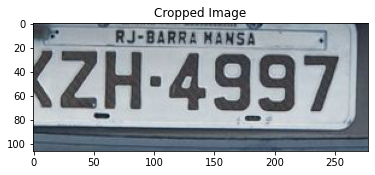

Done processing !!!


In [16]:
while cv2.waitKey(1) < 0:

    hasFrame, frame = cap.read()   
    if not hasFrame:
        print("Done processing !!!")
        break

    try:    
        blob = cv2.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)

        net.setInput(blob)

        outs = net.forward(getOutputsNames(net))

        cropped = postprocess(frame, outs)

        plt.imshow(frame)
        plt.title("localizacao")
        plt.show()
        plt.imshow(cropped)
        plt.title("Cropped Image")
        plt.show()
    except Exception as e:
        print(e)

## Character Segmentation
Character segmentation is an operation that seeks to decompose an image of a sequence of characters into subimages of individual symbols. It is one of the decision processes in a system for optical character recognition (OCR).

This phase contains the use of two functions: ```segment_characters()``` and ```find_contours()```.

In [17]:

def find_contours(dimensions, img) :
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) 
            char_copy = np.zeros((44,24))
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')
            plt.title('Predict Segments')

            char = cv2.subtract(255, char)

            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy)
            
            
    plt.show()
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])
    img_res = np.array(img_res_copy)

    return img_res

TypeError: Invalid shape () for image data

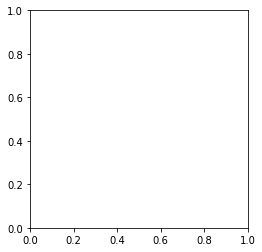

In [32]:

    

    
def sort_contours(cnts,reverse = False):
    i = 0
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))
    return cnts

plate_image = cv2.convertScaleAbs(cropped, alpha=(255.0))

# convert to grayscale and blur the image
gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray,(7,7),0)

# Applied inversed thresh_binary 
binary = cv2.threshold(blur, 180, 255,
                     cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[0]
## Applied dilation 
kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)

plt.imshow(binary)
cont, _  = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# creat a copy version "test_roi" of plat_image to draw bounding box
test_roi = plate_image.copy()

# Initialize a list which will be used to append charater image
crop_characters = []

# define standard width and height of character
digit_w, digit_h = 30, 60

for c in sort_contours(cont):
    (x, y, w, h) = cv2.boundingRect(c)
    ratio = h/w
    if 1<=ratio<=3.5: # Only select contour with defined ratio
        if h/plate_image.shape[0]>=0.5: # Select contour which has the height larger than 50% of the plate
            # Draw bounding box arroung digit number
            cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255,0), 2)

            # Sperate number and gibe prediction
            curr_num = thre_mor[y:y+h,x:x+w]
            curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
            _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            crop_characters.append(curr_num)
            
print("Detect {} letters...".format(len(crop_characters)))         

In [22]:
def segment_characters(image) :

   
    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.title('Contour')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

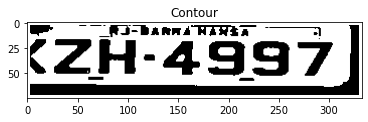

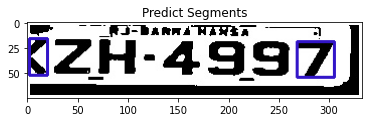

In [23]:
char=segment_characters(cropped)

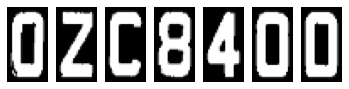

In [19]:
for i in range(len(char)):
    plt.subplot(1, len(char), i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')
plt.show()

In [20]:
loaded_model = Sequential()
loaded_model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(MaxPooling2D(pool_size=(4, 4)))
loaded_model.add(Dropout(0.4))
loaded_model.add(Flatten())
loaded_model.add(Dense(128, activation='relu'))
loaded_model.add(Dense(36, activation='softmax'))
loaded_model.load_weights('checkpoints/my_checkpoint')

In [21]:
loaded_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 16)        23248     
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        131104    
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 64)        131136    
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 64)        65600     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                      

In [53]:
# Predicting the output
def fix_dimension(img): 
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img
        return new_img
  
def show_results(count):
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        predict_x=loaded_model.predict(img)[0] 
        y_=np.argmax(predict_x)
        #y_ = loaded_model.predict_classes(img)[0] #predicting the class
        character = dic[y_]
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    if plate_number==row:
        count+=1
    return plate_number,count

#print(show_results())

1/1 [==============================] - 0s 49ms/step


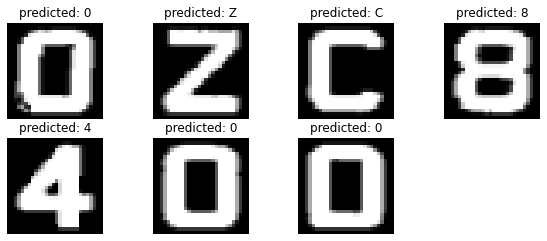

In [23]:
# Segmented characters and their predicted value.
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results()[i]}')
    plt.axis('off')
plt.show()

In [45]:
files=os.listdir(r"test_dataset/images")
k =0
concat= []
for i in files:
    k=k+1
    input_path = 'test_dataset/images/'+i
    os.rename(input_path,'test_dataset/images/'+str(k)+'.jpg')
    foto = i.replace('jpg','')
    df=pd.DataFrame({
        'ID':[k],
        'NUMBER':[foto]
    })
    concat.append(df)

In [46]:
df = pd.concat(concat)
df

,ID,NUMBER
0,1,2.
0,2,AYO9034.
0,3,AZJ6991.
0,4,FZB9581.
0,5,GWT2180.
...,...,...
0,111,PVX0095.
0,112,PWC0633.
0,113,PWF3266.
0,114,PXP8172.


In [47]:
df.to_csv('test_dataset/labels.csv',index= False)

In [62]:
labels=pd.read_csv('test_dataset/labels.csv')
labels['ID']=labels['ID'].map(str)
labels

,ID,NUMBER
0,2,AYO9034
1,3,AZJ6991
2,4,FZB9581
3,5,GWT2180
4,6,HPM9362
...,...,...
109,111,PVX0095
110,112,PWC0633
111,113,PWF3266
112,114,PXP8172


1


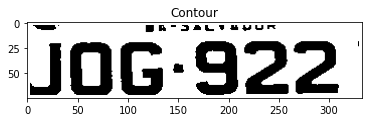

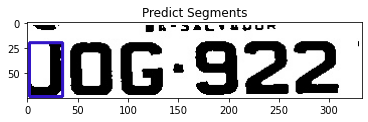

1/1 [==============================] - 0s 33ms/step
[2022/05/24 17:35:39] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

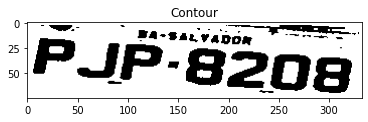

[2022/05/24 17:35:44] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='3, 32, 320', rec_batch_num=6, max_text_length=25, re

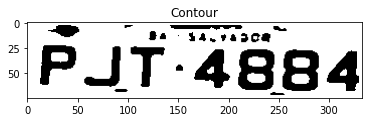

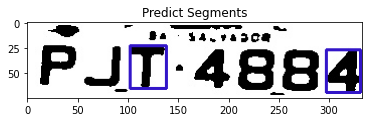

1/1 [==============================] - 0s 31ms/step
[2022/05/24 17:35:49] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

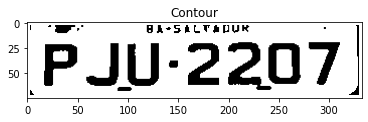

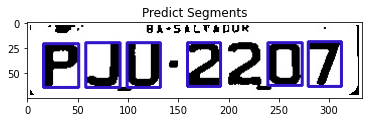

1/1 [==============================] - 0s 24ms/step
[2022/05/24 17:35:53] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

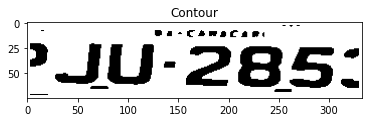

[2022/05/24 17:35:56] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='3, 32, 320', rec_batch_num=6, max_text_length=25, re

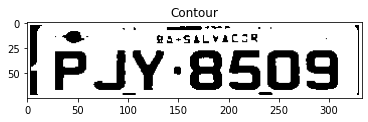

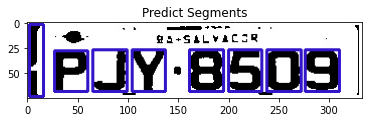

1/1 [==============================] - 0s 21ms/step
7


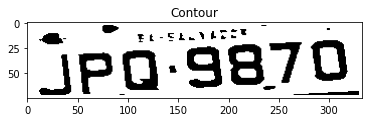

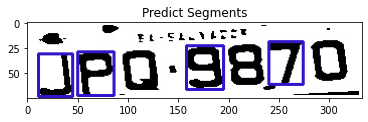

1/1 [==============================] - 0s 32ms/step
[2022/05/24 17:36:06] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

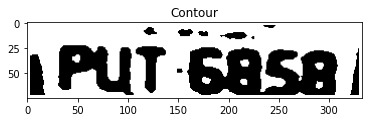

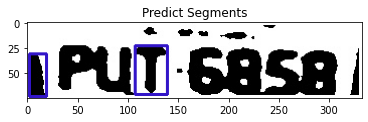

1/1 [==============================] - 0s 30ms/step
[2022/05/24 17:36:10] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

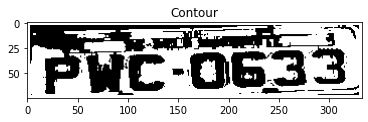

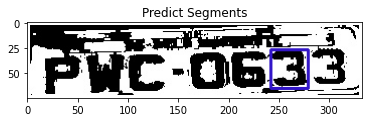

1/1 [==============================] - 0s 32ms/step
[2022/05/24 17:36:15] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

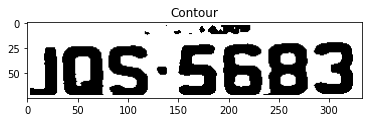

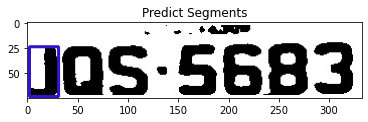

1/1 [==============================] - 0s 35ms/step
[2022/05/24 17:36:23] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

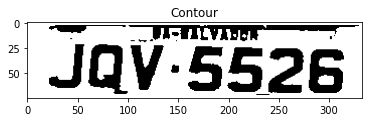

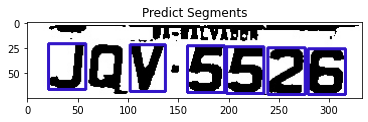

1/1 [==============================] - 0s 24ms/step
[2022/05/24 17:36:28] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

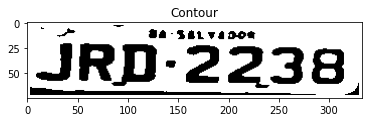

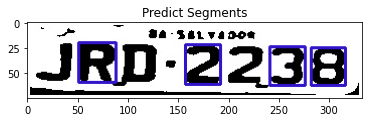

1/1 [==============================] - 0s 33ms/step
[2022/05/24 17:36:32] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

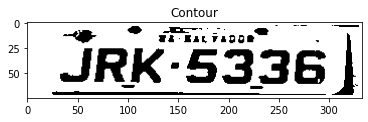

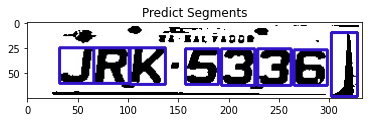

1/1 [==============================] - 0s 30ms/step
14


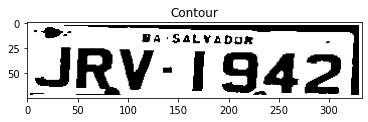

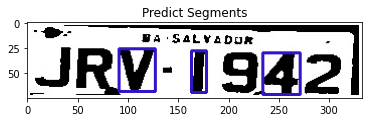

1/1 [==============================] - 0s 31ms/step
[2022/05/24 17:36:39] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

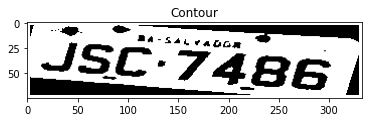

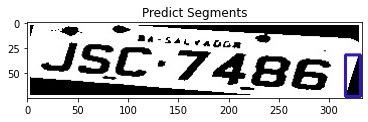

1/1 [==============================] - 0s 30ms/step
[2022/05/24 17:36:43] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

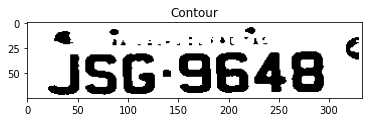

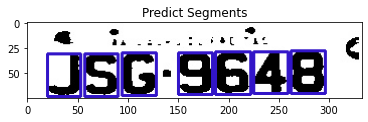

1/1 [==============================] - 0s 36ms/step
17


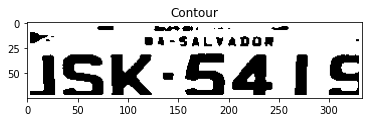

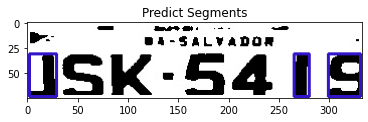

1/1 [==============================] - 0s 31ms/step
[2022/05/24 17:36:49] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

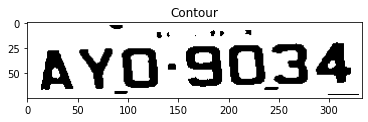

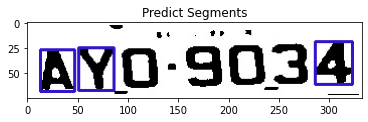

1/1 [==============================] - 0s 31ms/step
[2022/05/24 17:36:54] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

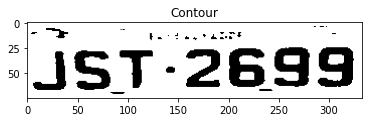

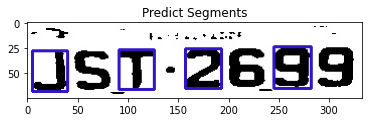

1/1 [==============================] - 0s 31ms/step
[2022/05/24 17:37:00] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

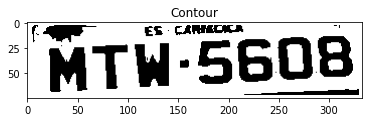

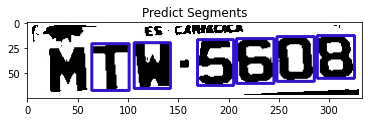

1/1 [==============================] - 0s 29ms/step
[2022/05/24 17:37:04] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

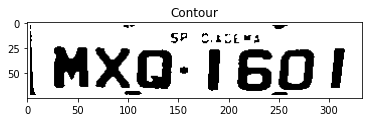

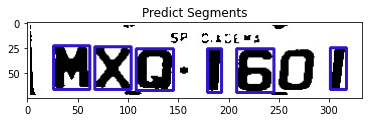

1/1 [==============================] - 0s 34ms/step
[2022/05/24 17:37:08] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

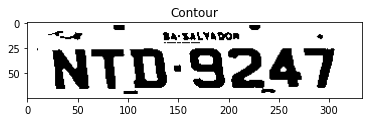

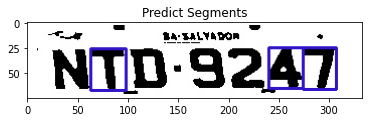

1/1 [==============================] - 0s 26ms/step
[2022/05/24 17:37:13] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

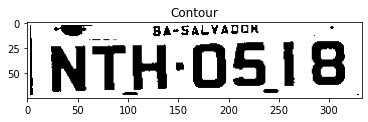

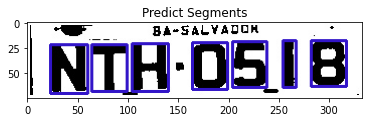

1/1 [==============================] - 0s 26ms/step
24


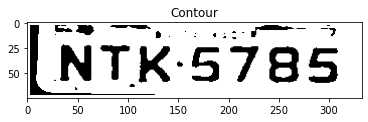

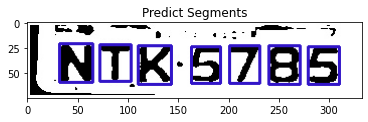

1/1 [==============================] - 0s 31ms/step
25


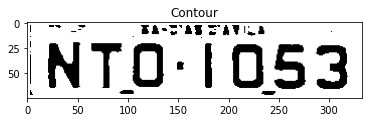

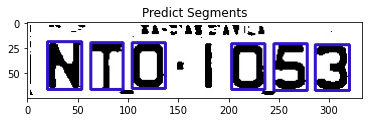

1/1 [==============================] - 0s 29ms/step
[2022/05/24 17:37:21] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

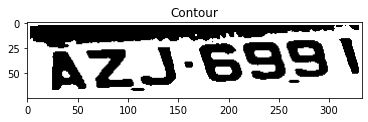

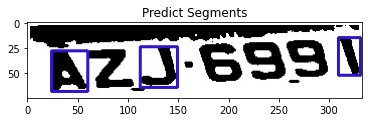

1/1 [==============================] - 0s 30ms/step
[2022/05/24 17:37:25] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

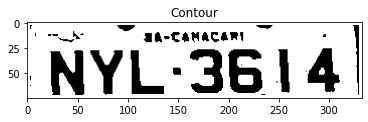

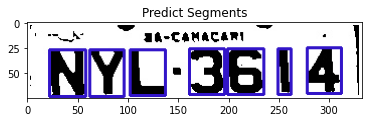

1/1 [==============================] - 0s 30ms/step
28


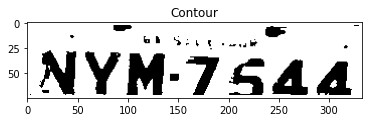

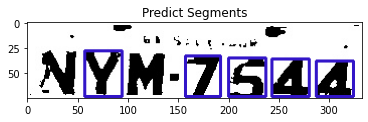

1/1 [==============================] - 0s 29ms/step
[2022/05/24 17:37:34] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

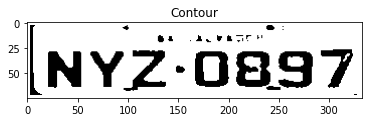

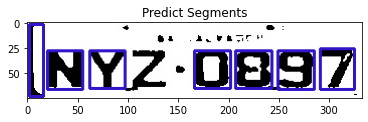

1/1 [==============================] - 0s 30ms/step
30


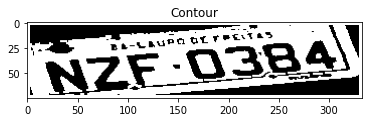

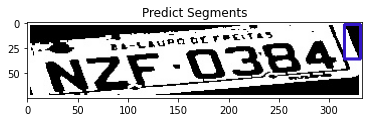

1/1 [==============================] - 0s 32ms/step
[2022/05/24 17:37:41] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

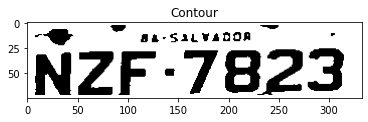

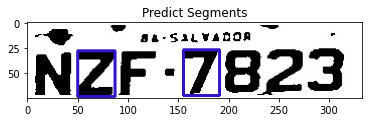

1/1 [==============================] - 0s 32ms/step
[2022/05/24 17:37:44] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

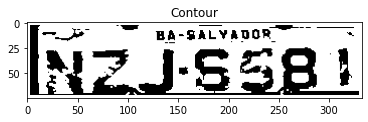

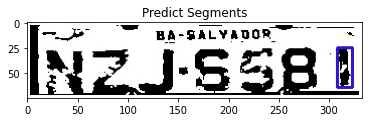

1/1 [==============================] - 0s 24ms/step
[2022/05/24 17:37:48] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

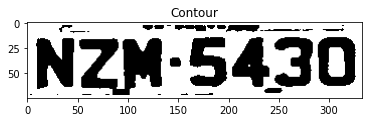

[2022/05/24 17:37:51] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='3, 32, 320', rec_batch_num=6, max_text_length=25, re

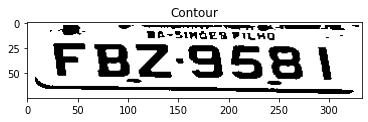

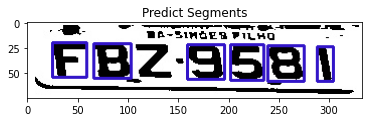

1/1 [==============================] - 0s 33ms/step
[2022/05/24 17:37:55] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

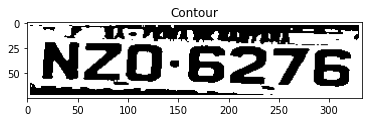

[2022/05/24 17:37:58] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='3, 32, 320', rec_batch_num=6, max_text_length=25, re

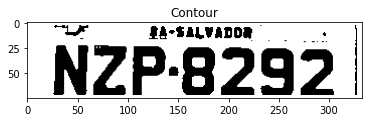

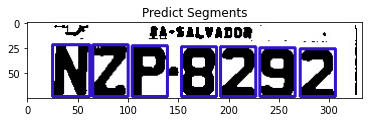

1/1 [==============================] - 0s 37ms/step
37


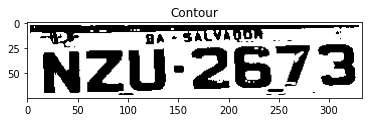

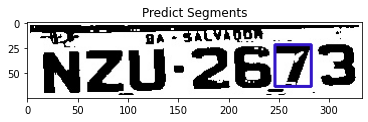

1/1 [==============================] - 0s 29ms/step
[2022/05/24 17:38:05] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

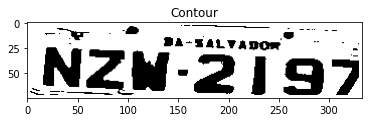

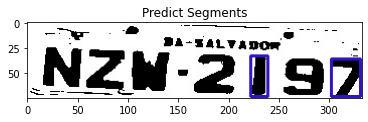

1/1 [==============================] - 0s 40ms/step
[2022/05/24 17:38:08] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

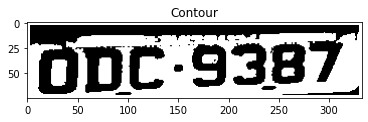

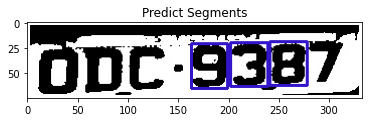

1/1 [==============================] - 0s 32ms/step
[2022/05/24 17:38:14] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

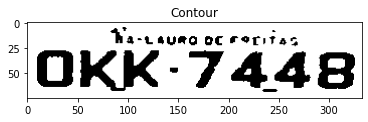

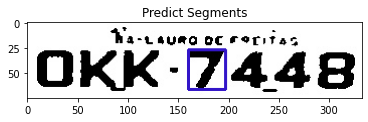

1/1 [==============================] - 0s 31ms/step
[2022/05/24 17:38:21] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

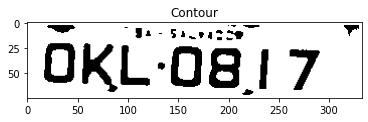

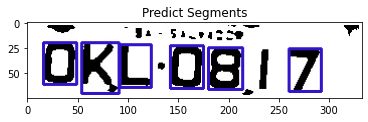

1/1 [==============================] - 0s 18ms/step
[2022/05/24 17:38:25] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

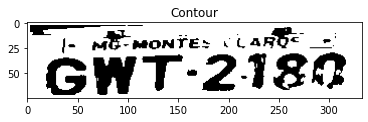

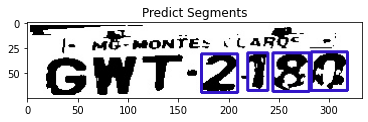

1/1 [==============================] - 0s 30ms/step
[2022/05/24 17:38:30] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

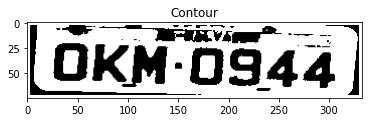

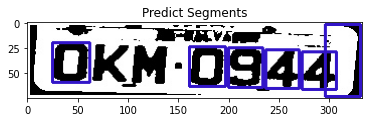

1/1 [==============================] - 0s 29ms/step
[2022/05/24 17:38:35] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

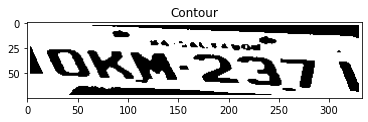

[2022/05/24 17:38:39] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='3, 32, 320', rec_batch_num=6, max_text_length=25, re

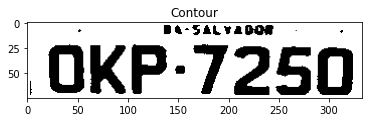

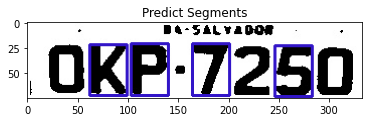

1/1 [==============================] - 0s 31ms/step
[2022/05/24 17:38:43] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

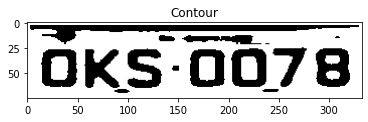

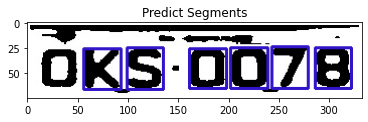

1/1 [==============================] - 0s 30ms/step
[2022/05/24 17:38:47] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

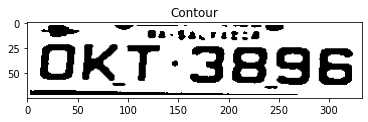

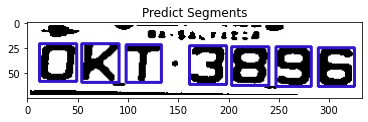

1/1 [==============================] - 0s 27ms/step
48


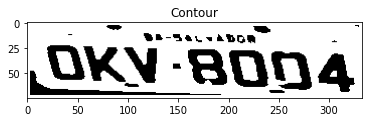

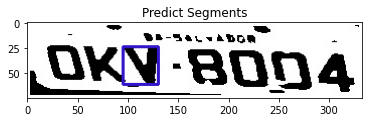

1/1 [==============================] - 0s 23ms/step
[2022/05/24 17:38:54] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

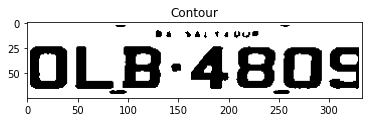

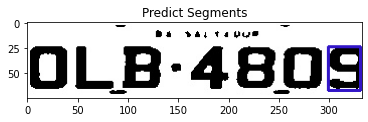

1/1 [==============================] - 0s 30ms/step
[2022/05/24 17:38:58] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

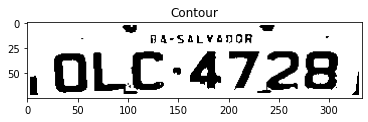

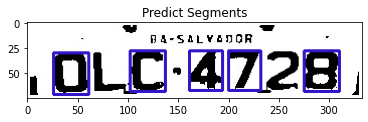

1/1 [==============================] - 0s 38ms/step
[2022/05/24 17:39:02] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

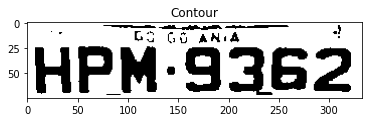

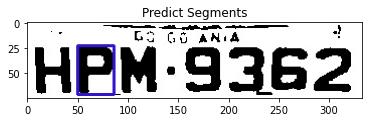

1/1 [==============================] - 0s 34ms/step
[2022/05/24 17:39:05] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

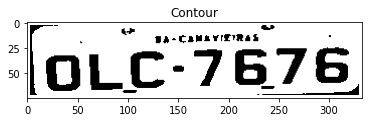

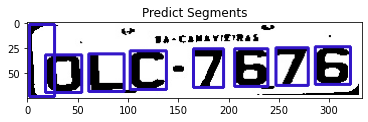

1/1 [==============================] - 0s 33ms/step
53


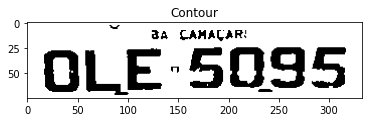

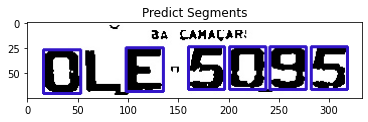

1/1 [==============================] - 0s 33ms/step
[2022/05/24 17:39:11] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

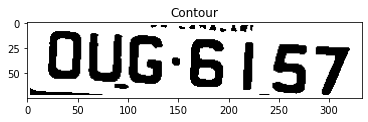

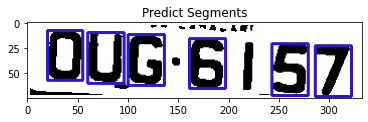

1/1 [==============================] - 0s 25ms/step
[2022/05/24 17:39:14] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

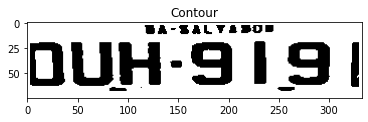

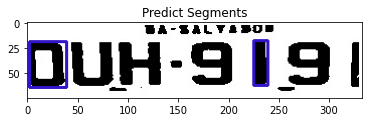

1/1 [==============================] - 0s 27ms/step
[2022/05/24 17:39:17] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

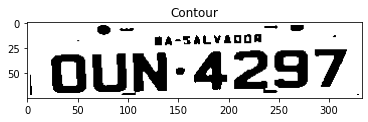

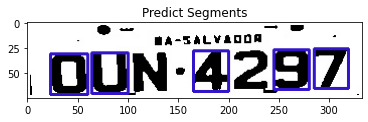

1/1 [==============================] - 0s 25ms/step
[2022/05/24 17:39:22] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

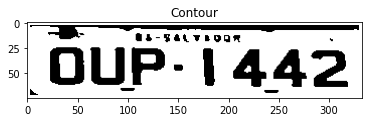

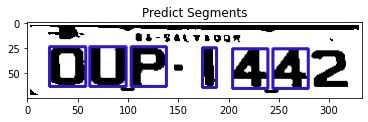

1/1 [==============================] - 0s 37ms/step
[2022/05/24 17:39:26] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

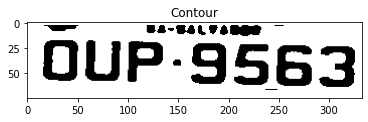

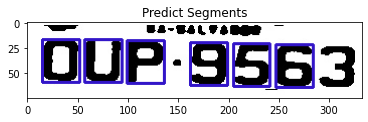

1/1 [==============================] - 0s 23ms/step
[2022/05/24 17:39:30] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

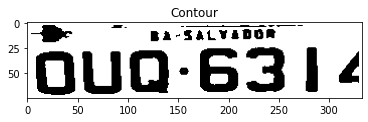

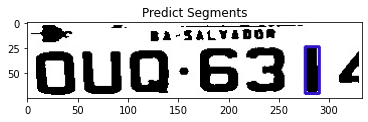

1/1 [==============================] - 0s 22ms/step
[2022/05/24 17:39:33] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

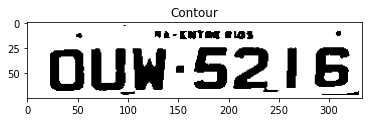

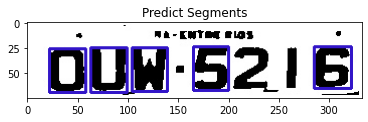

1/1 [==============================] - 0s 26ms/step
[2022/05/24 17:39:36] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

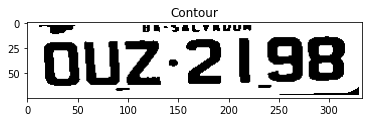

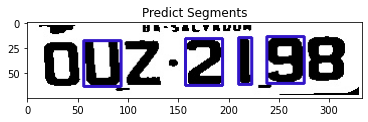

1/1 [==============================] - 0s 33ms/step
[2022/05/24 17:39:41] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

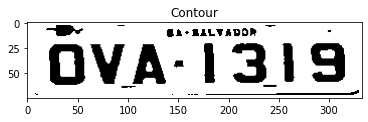

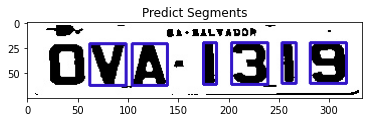

1/1 [==============================] - 0s 39ms/step
[2022/05/24 17:39:45] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

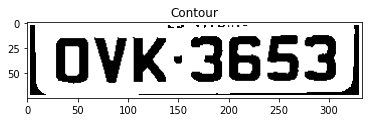

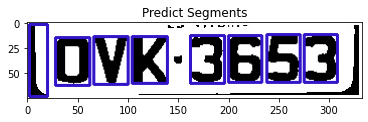

1/1 [==============================] - 0s 35ms/step
64


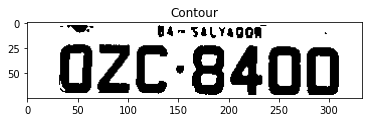

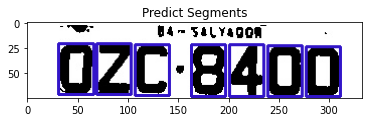

1/1 [==============================] - 0s 40ms/step
65


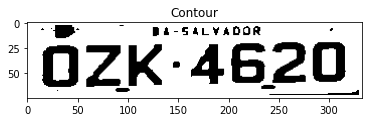

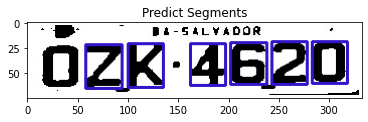

1/1 [==============================] - 0s 35ms/step
[2022/05/24 17:39:57] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

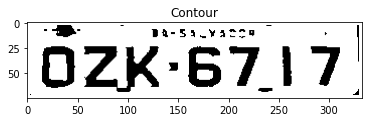

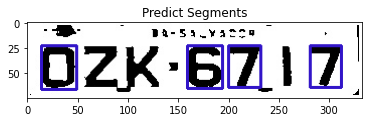

1/1 [==============================] - 0s 34ms/step
[2022/05/24 17:40:02] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

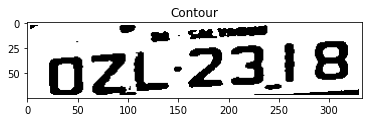

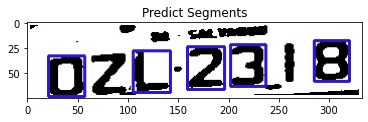

1/1 [==============================] - 0s 26ms/step
[2022/05/24 17:40:06] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

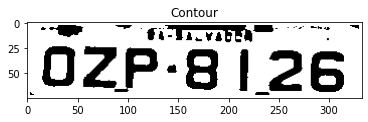

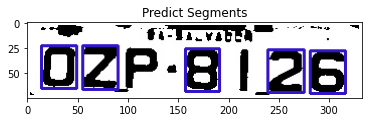

1/1 [==============================] - 0s 23ms/step
[2022/05/24 17:40:10] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

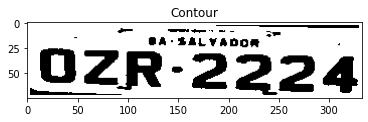

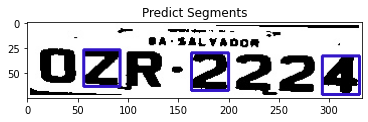

1/1 [==============================] - 0s 23ms/step
[2022/05/24 17:40:16] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

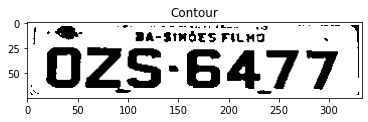

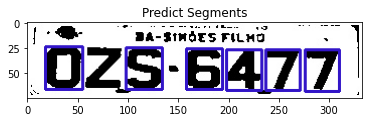

1/1 [==============================] - 0s 36ms/step
[2022/05/24 17:40:21] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

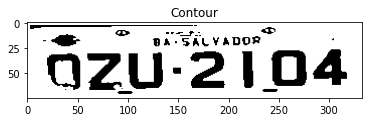

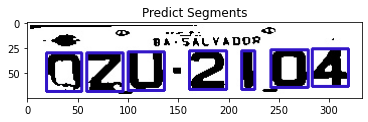

1/1 [==============================] - 0s 33ms/step
72


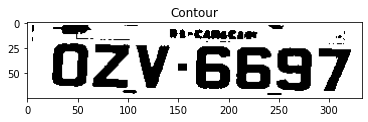

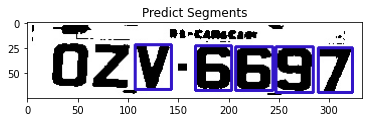

1/1 [==============================] - 0s 33ms/step
[2022/05/24 17:40:30] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

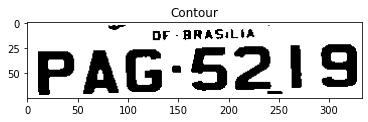

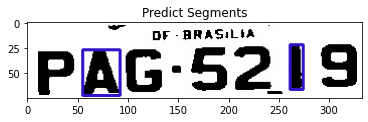

1/1 [==============================] - 0s 32ms/step
[2022/05/24 17:40:34] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

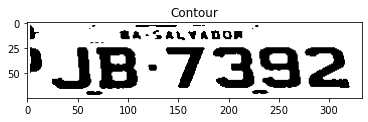

[2022/05/24 17:40:39] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='3, 32, 320', rec_batch_num=6, max_text_length=25, re

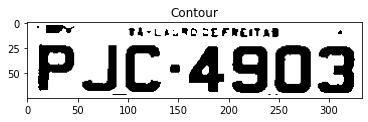

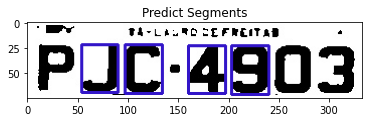

1/1 [==============================] - 0s 33ms/step
[2022/05/24 17:40:42] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

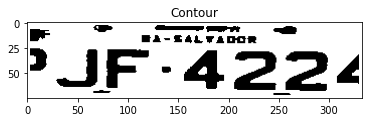

[2022/05/24 17:40:48] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='3, 32, 320', rec_batch_num=6, max_text_length=25, re

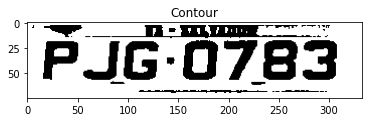

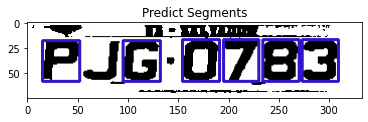

1/1 [==============================] - 0s 28ms/step
[2022/05/24 17:40:53] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

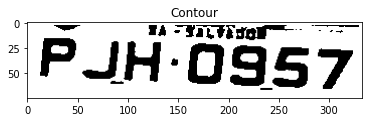

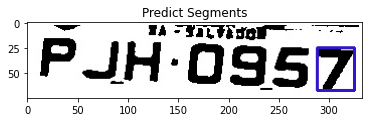

1/1 [==============================] - 0s 32ms/step
[2022/05/24 17:40:57] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

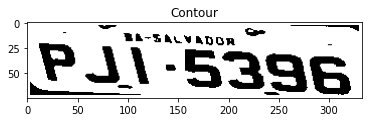

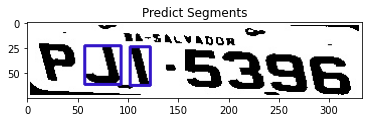

1/1 [==============================] - 0s 24ms/step
[2022/05/24 17:41:00] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

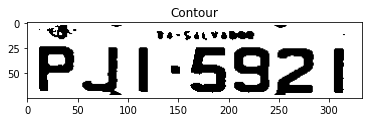

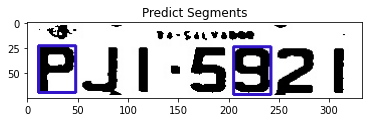

1/1 [==============================] - 0s 28ms/step
[2022/05/24 17:41:04] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

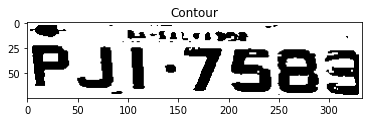

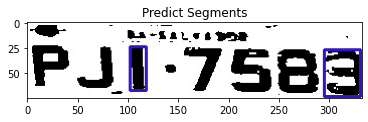

1/1 [==============================] - 0s 29ms/step
[2022/05/24 17:41:08] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

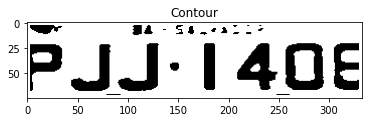

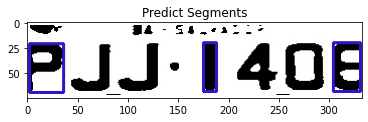

1/1 [==============================] - 0s 28ms/step
[2022/05/24 17:41:12] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

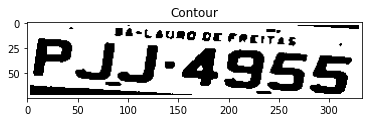

[2022/05/24 17:41:15] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='3, 32, 320', rec_batch_num=6, max_text_length=25, re

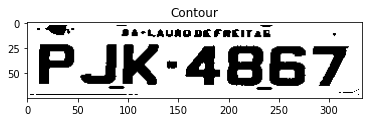

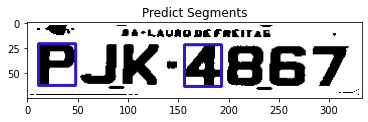

1/1 [==============================] - 0s 33ms/step
[2022/05/24 17:41:18] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\det\\en\\en_ppocr_mobile_v2.0_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='CRNN', rec_model_dir='C:\\Users\\jpedr/.paddleocr/whl\\rec\\en\\en_number_mobile_v2.0_rec_infer', rec_image_shape='

In [70]:
file_list=os.listdir(r"test_dataset/images")
count=0
k = 0
for path in file_list:
#for entry in labels['ID']:
    input_path = 'test_dataset/images/'+path
    is_video = False
    no=path[:-4]
    try:
        row=labels['NUMBER'].where(labels['ID'] == no).dropna().values[0]
    except:
        pass
    
    cap = cv2.VideoCapture(input_path)
    
    while cv2.waitKey(1) < 0:

        hasFrame, frame = cap.read()

        if not hasFrame:
            break
        try:
            blob = cv2.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)
        except:
            break

        net.setInput(blob)
        outs = net.forward(getOutputsNames(net))

        cropped = postprocess(frame, outs)
        if cropped is not None:
            k=k+1
            print(k)
            t, _ = net.getPerfProfile()
            label = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
            
            char=segment_characters(cropped)
            plate,count=show_results(count)
            if len(plate)<7:
                ocr_model = PaddleOCR(lang='en')
                result = ocr_model.ocr(frame)
                result
                for res in result:
                    print('placa ocr: ',res[1][0])
                    res1=res[1][0]
                resultado= str(res1).replace('-','')
                resultado = resultado.replace('.','')
                resultado = resultado.replace(':','')
                if resultado==row:
                    count+=1
            
                
print("Accuracy: "+str((count/84)*100)+"%")